# time delay

### Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceImage
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization

from tensorflow.keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping


### Datos

In [2]:

data = pd.read_csv('AAPL.csv', parse_dates=[0], dayfirst=True,header=None, index_col=0, names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])
features = ["Open","High","Low","Close","Volume"]
data_ = data[features].values.astype(float)  # (n_timestamps, n_features)
n_timestamps, n_features = data_.shape

# --- 1. Parámetros ---
embedding_dimension = 10  # número de lags
delay = 1                 # delay
window_size = 50          # tamaño de la ventana para la predicción
features = ["Open","High","Low","Close","Volume"]



In [3]:
# Función time-delay embedding
def time_delay_embedding(window, d=3, tau=1):
    W = len(window)
    m = W - (d-1)*tau
    if m <= 0:
        raise ValueError(f"Ventana demasiado corta: W={W}, d={d}, tau={tau}")
    emb = np.vstack([window[i:i+m] for i in range(0, d*tau, tau)]).T
    return emb


In [4]:
# --- Inicializar PH y Persistence Image ---
VR = VietorisRipsPersistence(homology_dimensions=[0,1])
PI = PersistenceImage(n_bins=20)

In [5]:
#data set
X = []
y = []

for i in range(n_timestamps - window_size - 1):
    window = data_[i : i + window_size]  # ventana (window_size, n_features)
    feat_window = []
    
    # Aplicar time-delay embedding a cada feature
    for f in range(n_features):
        series_f = window[:, f]
        embedded_f = time_delay_embedding(series_f, d=embedding_dimension, tau=delay)
        # PH
        diag = VR.fit_transform(embedded_f.reshape(1, embedded_f.shape[0], embedded_f.shape[1]))
        # Persistence image
        feat = PI.fit_transform(diag).reshape(-1)
        feat_window.append(feat)
    
    # Concatenar features topológicas de todas las columnas
    X.append(np.hstack(feat_window))
    
    # Target = siguiente Close
    y.append(data_[i + window_size, features.index("Close")])

X = np.array(X)
y = np.array(y)

print("X.shape =", X.shape)
print("y.shape =", y.shape)

X.shape = (3221, 4000)
y.shape = (3221,)


In [6]:
#### Desechable


X = []
y = []
fechas = []

for i in range(n_timestamps - window_size - 1):
    window = data_[i : i + window_size]  # ventana (window_size, n_features)
    feat_window = []
    
    for f in range(n_features):
        series_f = window[:, f]
        embedded_f = time_delay_embedding(series_f, d=embedding_dimension, tau=delay)
        #Dragrama de persistencia
        diag = VR.fit_transform(embedded_f.reshape(1, embedded_f.shape[0], embedded_f.shape[1]))
        #Transformarlo en persistance image
        feat = PI.fit_transform(diag).reshape(-1)
        feat_window.append(feat)
    
    X.append(np.hstack(feat_window))
    y.append(data_[i + window_size, features.index("Close")])
    
    # Guardar la fecha del target
    fecha_target = data.index[i + window_size]
    fechas.append(fecha_target)

X = np.array(X)
y = np.array(y)
fechas = np.array(fechas)

print("X.shape =", X.shape)
print("y.shape =", y.shape)
print("fechas.shape =", fechas.shape)

X.shape = (3221, 4000)
y.shape = (3221,)
fechas.shape = (3221,)


In [7]:
X

array([[2.59791709e+02, 2.42746522e+02, 1.98032379e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.69285970e+02, 2.51617855e+02, 2.05269604e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.75709861e+02, 2.57620268e+02, 2.10166367e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.19294993e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.19294993e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.19294993e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.11097827e-13]])

In [8]:
### Desechable

X_train, X_test, y_train, y_test, fechas_train, fechas_test = train_test_split(
    X, y, fechas, shuffle=False, test_size=0.2
)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [19]:



# red neuronal
model = Sequential([
    Dense(2048, activation='relu', input_shape=(X_train.shape[1],)),
    
    Dropout(0.3),
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    
    Dropout(0.3),
    Dense(512, activation='relu'),
    
    Dropout(0.3),
    Dense(256, activation='linear'),
    
    Dense(1, activation='linear')
])


'''model = Sequential([
    Dense(512, activation='swish', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='softplus'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='softplus'),
    Dense(1, activation='linear')  # salida continua
])
'''


optimizer = Adam(learning_rate=0.001)
model.compile(loss='huber', optimizer=optimizer, metrics=['mse', 'mae', 'r2_score'])

history = model.fit(X_train, y_train, epochs=100, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/100


c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 156.5256 - mae: 157.0235 - mse: 248486.3281 - r2_score: -858.9650 - val_loss: 133.9498 - val_mae: 134.4498 - val_mse: 18529.7949 - val_r2_score: -40.5263
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 17.6066 - mae: 18.1013 - mse: 577.4414 - r2_score: -1.1098 - val_loss: 124.4086 - val_mae: 124.9086 - val_mse: 16123.0000 - val_r2_score: -35.1325
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 12.5393 - mae: 13.0305 - mse: 336.9493 - r2_score: -0.2188 - val_loss: 125.3912 - val_mae: 125.8912 - val_mse: 16387.4648 - val_r2_score: -35.7252
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 10.8718 - mae: 11.3597 - mse: 278.4136 - r2_score: -0.0050 - val_loss: 124.8937 - val_mae: 125.3937 - val_mse: 16238.3506 - val_r2_score: -35.3910
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 8.6761 - mae: 9.1615 - mse: 179.1368 - r2_score: 0.3292 - val_loss: 124.7916 - val_mae: 125.2916 - val_mse: 1621

In [17]:

y_pred = model.predict(X_test)
#Close usando Time-delay embedding + PH + PI + MLP

'''import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Real Close")
plt.plot(y_pred, label="Predicho Close")
plt.legend()
plt.title("Predicción ")
plt.show()'''


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


'import matplotlib.pyplot as plt\nplt.figure(figsize=(10,5))\nplt.plot(y_test, label="Real Close")\nplt.plot(y_pred, label="Predicho Close")\nplt.legend()\nplt.title("Predicción ")\nplt.show()'

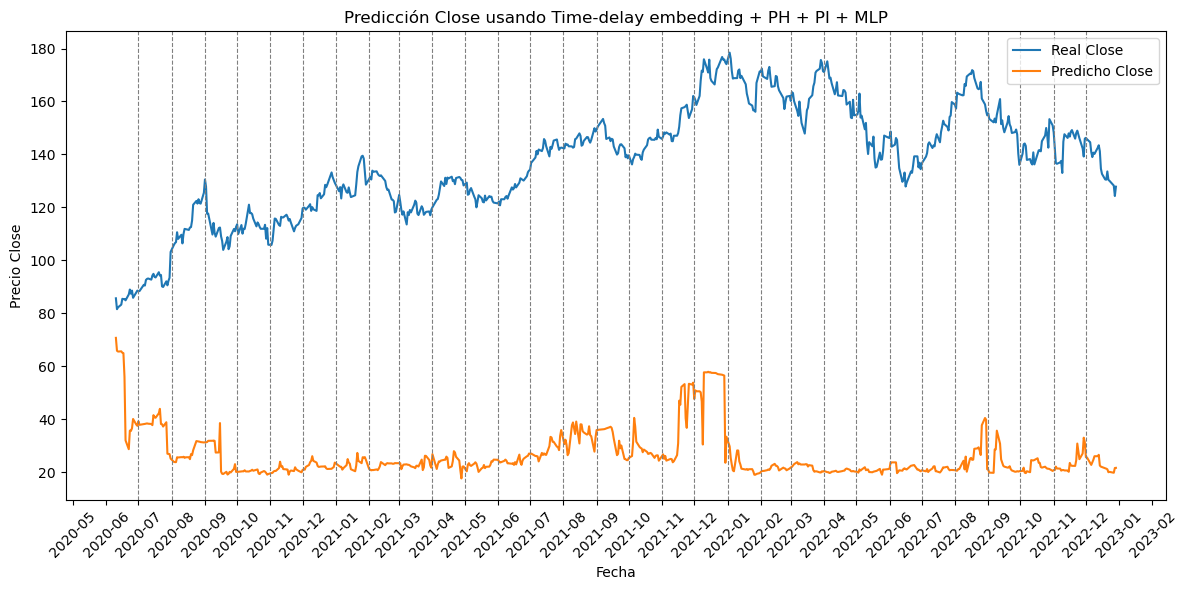

In [18]:
import matplotlib.dates as mdates

# Crear la figura
plt.figure(figsize=(12, 6))

# Graficar los valores reales y predichos
plt.plot(fechas_test, y_test, label="Real Close")
plt.plot(fechas_test, y_pred, label="Predicho Close")

# Agregar líneas verticales para separar los meses
for fecha in pd.date_range(start=fechas_test.min(), end=fechas_test.max(), freq='MS'):
    plt.axvline(x=fecha, color='gray', linestyle='--', linewidth=0.8)

# Configurar el formato de las fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Configurar leyendas, títulos y etiquetas
plt.legend()
plt.title("Predicción Close usando Time-delay embedding + PH + PI + MLP")
plt.xlabel("Fecha")
plt.ylabel("Precio Close")
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()
